# PREDICCIÓN DE PORCENTAJES DE CONSUMO DE LAS CUOTAS ASIGNADAS AL STOCK **JAX/08C.**

##IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE FUNCIONES

In [ ]:
# Instalación de librería skforecast
# ==============================================================================
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.3/397.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [ ]:
# Carga de datos
# ==============================================================================
import io
from google.colab import files

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import datetime

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import itertools
import seaborn as sns

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

# Random State
# ==============================================================================
rs = 42

## CARGA DE DATOS

- Alternativa 1: Conectando con Google Drive y abriendo el fichero desde el mismo:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D3_Resumen.csv', delimiter=';', encoding='latin-1', decimal=',')
datos = datos.loc[(datos['Stock'] == 'JAX/08C.')]
datos.head()

,Año,Semestre,Cuatrimestre,Trimestre,Mes,SemanaAño,FcCaptura,IdStock,Stock,PesoCapturadoTotalDía,AcumuladoDía,CuotaStock,Porcentaje
0,2018,1,1,1,1,1,02/01/2018,99157877,JAX/08C.,7031.0,7031.0,25563080.0,0.03
1,2018,1,1,1,1,1,03/01/2018,99157877,JAX/08C.,23481.0,30512.0,25563080.0,0.12
2,2018,1,1,1,1,1,04/01/2018,99157877,JAX/08C.,5151.0,35663.0,25563080.0,0.14
3,2018,1,1,1,1,1,05/01/2018,99157877,JAX/08C.,2579.0,38242.0,25563080.0,0.15
4,2018,1,1,1,1,1,06/01/2018,99157877,JAX/08C.,276.0,38518.0,25563080.0,0.15


- Alternativa 2: Subiendo fichero a Google Colab:

In [ ]:
# #Definiendo una función que permita cargar los datos desde una ubicación seleccionada:
# def upload_files ():
#   uploaded = files.upload()
#   for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded[fn])))
#     df = pd.read_csv(io.StringIO(uploaded[fn].decode('latin-1')),delimiter=';',decimal=',')
#     return df

# df = upload_files()

# #Muestra del dataset:
# df.head()

- Alternativa 3: Fichero ya subido a Google Colab:

In [ ]:
# df = pd.read_csv('D3_Resumen.csv',encoding='latin-1',delimiter=';',decimal=',')
# df.head()

##EXPLORACIÓN Y PROCESAMIENTO DE DATOS

#### Dimensiones y tipología de datos

In [ ]:
#Dimensiones dataset:
datos.shape

(1630, 13)

In [ ]:
#Tipología de datos:
datos.dtypes

Año                        int64
Semestre                   int64
Cuatrimestre               int64
Trimestre                  int64
Mes                        int64
SemanaAño                  int64
FcCaptura                 object
IdStock                    int64
Stock                     object
PesoCapturadoTotalDía    float64
AcumuladoDía             float64
CuotaStock               float64
Porcentaje               float64
dtype: object

#### Missing values

In [ ]:
#Evaluación de valores nulos:
pd.isnull(datos).sum()

Año                      0
Semestre                 0
Cuatrimestre             0
Trimestre                0
Mes                      0
SemanaAño                0
FcCaptura                0
IdStock                  0
Stock                    0
PesoCapturadoTotalDía    0
AcumuladoDía             0
CuotaStock               0
Porcentaje               0
dtype: int64

In [ ]:
for col in datos.columns:
    pct_missing = np.mean(datos[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Año - 0%
Semestre - 0%
Cuatrimestre - 0%
Trimestre - 0%
Mes - 0%
SemanaAño - 0%
FcCaptura - 0%
IdStock - 0%
Stock - 0%
PesoCapturadoTotalDía - 0%
AcumuladoDía - 0%
CuotaStock - 0%
Porcentaje - 0%


In [ ]:
#Eliminación de las instancias con missing values:
datos = datos.dropna()

## PREPARACIÓN DE DATOS

#### Selección de subconjuntos de datos

In [ ]:
# Dataframes con la información necesaria:
# ==============================================================================
features = ['FcCaptura', 'Porcentaje']
df_JAX = pd.DataFrame(data=datos, columns=features)
print(df_JAX.head())
print(df_JAX.tail())

    FcCaptura  Porcentaje
0  02/01/2018        0.03
1  03/01/2018        0.12
2  04/01/2018        0.14
3  05/01/2018        0.15
4  06/01/2018        0.15
       FcCaptura  Porcentaje
2397  26/12/2022       67.29
2398  27/12/2022       67.39
2399  28/12/2022       67.39
2400  29/12/2022       67.42
2401  30/12/2022       67.42


#### Comprobación de completitud de la serie temporal

In [ ]:
# Se crea el campo Date a partir de FcCaptura (tipología de datos datetime):
# ==============================================================================
df_JAX['Date'] = pd.to_datetime(df_JAX['FcCaptura'], format = '%d/%m/%Y')

In [ ]:
# Se examinan los datos, analizando si faltan fechas:
# ==============================================================================
print('---------------------------------------')
print('INFORMACIÓN STOCK JAX/08C.:')
print('---------------------------------------')
print('Fecha mínima: ' + str(df_JAX['Date'].min()))
print('Fecha máxima: ' + str(df_JAX['Date'].max())+'\n')

---------------------------------------
INFORMACIÓN STOCK JAX/08C.:
---------------------------------------
Fecha mínima: 2018-01-02 00:00:00
Fecha máxima: 2022-12-30 00:00:00



Si se necesita que el stock contemple las fechas comprendidas entre el 01/01/2018 y el 31/12/2022 se tendría que:

**• JAX/08C.**

- Incluir los días 01/01/2018, 01/01/2020, 01/01/2021, 01/01/2022, 31/12/2021, 31/12/2022.
- Incluir el porcentaje del día 31/12/2021: 74,89.
- Incluir los días faltantes en los que no se haya acumulado porcentaje. Estos días se incluirán de la siguiente forma: para los días "previos" el porcentaje será 0 (peso capturado = 0), y para los días "posteriores" el porcentaje será el último porcentaje válido.

In [ ]:
#Se definen y calculan los datos faltantes:
FcIni2018 = '01/01/2018'
FcIni2020 = '01/01/2020'
FcIni2021 = '01/01/2021'
FcIni2022 = '01/01/2022'
FcFin2021 = '31/12/2021'
FcFin2022 = '31/12/2022'
PrcFin2021 = 74.89

v_JAX=[(FcIni2018,0),
       (FcIni2020,0),
       (FcIni2021,0),
       (FcIni2022,0),
       (FcFin2021,PrcFin2021),
       (FcFin2022,df_JAX[df_JAX['Date']==df_JAX['Date'].max()]['Porcentaje'][df_JAX[df_JAX['Date']==df_JAX['Date'].max()]['Porcentaje'].index[0]])]
print((FcIni2018,0),
       (FcIni2020,0),
       (FcIni2021,0),
       (FcIni2022,0),
       (FcFin2021,PrcFin2021),
       (FcFin2022,df_JAX[df_JAX['Date']==df_JAX['Date'].max()]['Porcentaje'][df_JAX[df_JAX['Date']==df_JAX['Date'].max()]['Porcentaje'].index[0]]))

('01/01/2018', 0) ('01/01/2020', 0) ('01/01/2021', 0) ('01/01/2022', 0) ('31/12/2021', 74.89) ('31/12/2022', 67.42)


In [ ]:
# Se añaden los días faltantes:
# Se añaden únicamente el primer y último día del período de estudio, ya que el resto se completarán en pasos posteriores.
# ==============================================================================
valores_JAX = v_JAX
            #[('01/01/2018',0),('31/12/2022',67.66)]

nuevo_df_JAX = pd.DataFrame(valores_JAX,columns=features)
nuevo_df_JAX['Date'] = pd.to_datetime(nuevo_df_JAX['FcCaptura'], format = '%d/%m/%Y')
nuevo_df_JAX.head()

,FcCaptura,Porcentaje,Date
0,01/01/2018,0.00,2018-01-01
1,01/01/2020,0.00,2020-01-01
2,01/01/2021,0.00,2021-01-01
3,01/01/2022,0.00,2022-01-01
4,31/12/2021,74.89,2021-12-31


In [ ]:
# Se concatenan los dataframes y se ordenan en función de la fecha:
# ==============================================================================
df_JAX = pd.concat([df_JAX,nuevo_df_JAX],ignore_index=True)
df_JAX = df_JAX.sort_values('Date')
df_JAX.head()

,FcCaptura,Porcentaje,Date
1630,01/01/2018,0.00,2018-01-01
0,02/01/2018,0.03,2018-01-02
1,03/01/2018,0.12,2018-01-03
2,04/01/2018,0.14,2018-01-04
3,05/01/2018,0.15,2018-01-05


In [ ]:
# Se pasa el campo fecha como índice:
# ==============================================================================
df_JAX2 = df_JAX.set_index('Date', drop = True, append = False, inplace = False, verify_integrity = True)
df_JAX2.head()

,FcCaptura,Porcentaje
Date,,
2018-01-01,01/01/2018,0.00
2018-01-02,02/01/2018,0.03
2018-01-03,03/01/2018,0.12
2018-01-04,04/01/2018,0.14
2018-01-05,05/01/2018,0.15


In [ ]:
# Se examinan de nuevo los datos, analizando si faltan fechas min/max:
# ==============================================================================
print('---------------------------------------')
print('INFORMACIÓN STOCK JAX/08C.:')
print('---------------------------------------')
print('Fecha mínima: ' + str(df_JAX2.index.min()))
print('Fecha máxima: ' + str(df_JAX2.index.max()))

---------------------------------------
INFORMACIÓN STOCK JAX/08C.:
---------------------------------------
Fecha mínima: 2018-01-01 00:00:00
Fecha máxima: 2022-12-31 00:00:00


In [ ]:
# Se completa el índice para que tenga una frecuencia continua (cogiendo el registro anterior válido)
# (tiene sentido porque el % va a ser el mismo que el del día anterior, ya que no se ha pescado nada)
# ==============================================================================
print('Dimensiones anteriores JAX/08C.: ' + str(df_JAX2.shape))
df_JAX2 = df_JAX2.asfreq(freq="d",method='pad')
print('Dimensiones actuales JAX/08C.: ' + str(df_JAX2.shape))

Dimensiones anteriores JAX/08C.: (1636, 2)
Dimensiones actuales JAX/08C.: (1826, 2)


In [ ]:
# Verify that a temporary index is complete
# ==============================================================================
print('¿Índice JAX/08C. completo?: ' + str((df_JAX2.index == pd.date_range(start=df_JAX2.index.min(), end=df_JAX2.index.max(), freq=df_JAX2.index.freq)).all()))

¿Índice JAX/08C. completo?: True


In [ ]:
print('Nº REGISTROS STOCK JAX/08C.: ' + str(df_JAX2.shape[0]))

Nº REGISTROS STOCK JAX/08C.: 1826


#### Exportación de la serie temporal completa (para análisis de la misma en RStudio)

In [ ]:
#Exportación de dataset:
JAX_R = df_JAX2.reset_index()
JAX_R.to_excel('D3_JAX_Completo.xlsx')

In [ ]:
# data = df_JAX2.to_numpy()
# prueba = series_to_supervised(data)
# print(prueba)

##ENTRENAMIENTO Y PREDICCIÓN

### Stock JAX/08C.

#### Random Forest Regressor

365
Train dates : 2018-01-01 00:00:00 --- 2021-12-31 00:00:00  (n=1461)
Test dates  : 2022-01-01 00:00:00 --- 2022-12-31 00:00:00  (n=365)


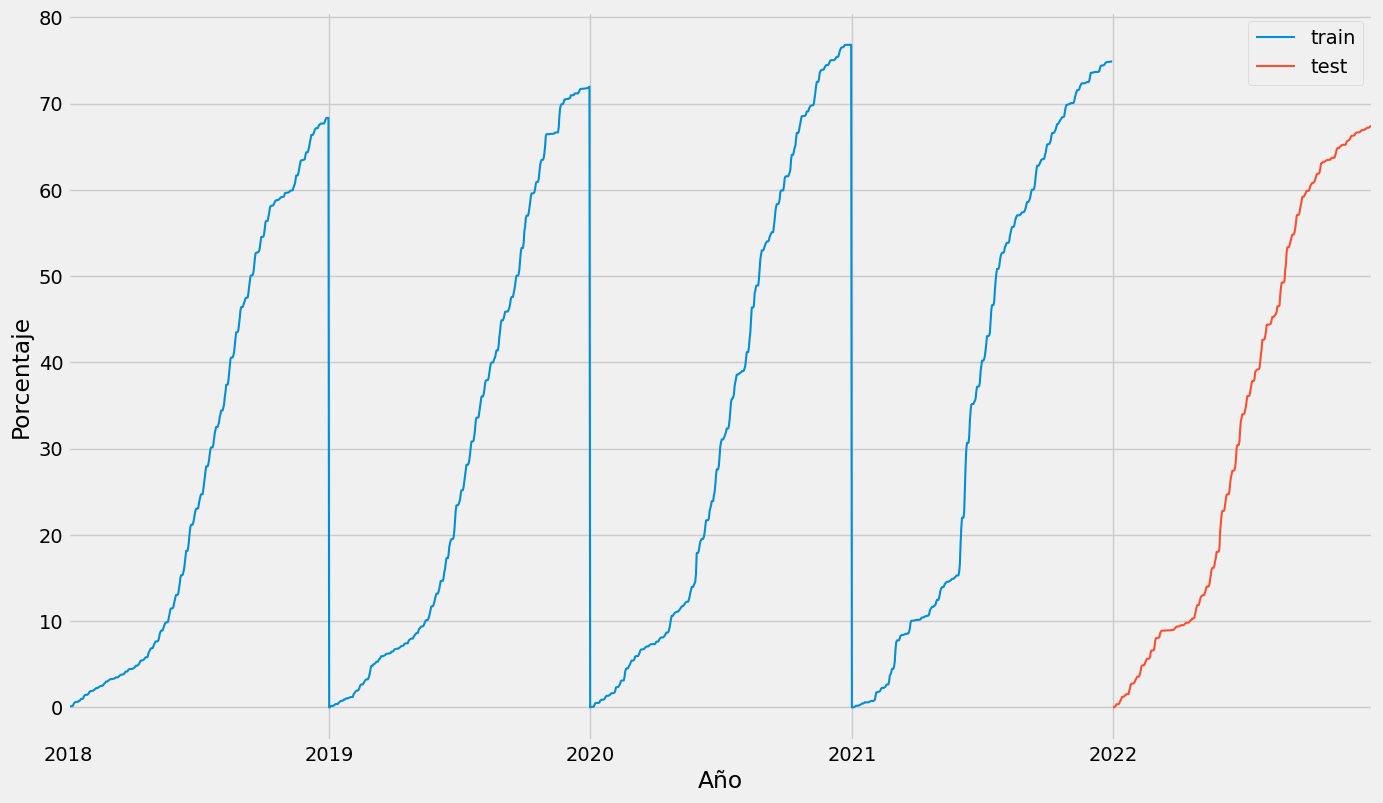

In [ ]:
# Split data into train-val-test
# ==============================================================================
steps = int(df_JAX2.shape[0]*0.2)
data_train = df_JAX2[:-steps]
data_test  = df_JAX2[-steps:]

print(steps)
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(15, 9))
data_train['Porcentaje'].plot(ax=ax, label='train')
data_test['Porcentaje'].plot(ax=ax, label='test')
plt.xlabel('Año')
plt.ylabel('Porcentaje')
ax.legend();

##### Número de predictores: 365

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=rs),
                lags      = 365
             )
#Importante: lags = 730 significa que, el modelo, utiliza como predictores los 730 días anteriores.
#(Esto depende de la frecuencia indicada en los datos, si ésta fuera MS (meses), significaría que está cogiendo los 730 meses anteriores)

forecaster.fit(y=data_train['Porcentaje'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228

In [ ]:
# Predictions
# ==============================================================================
steps = int(df_JAX2.shape[0]*0.2)
predictions = forecaster.predict(steps=steps)
predictions.head(10)

2022-01-01    27.6088
2022-01-02    16.1629
2022-01-03    14.8237
2022-01-04     6.5996
2022-01-05     4.5041
2022-01-06     3.2299
2022-01-07     2.8357
2022-01-08     2.4389
2022-01-09     2.0231
2022-01-10     1.7382
Freq: D, Name: pred, dtype: float64

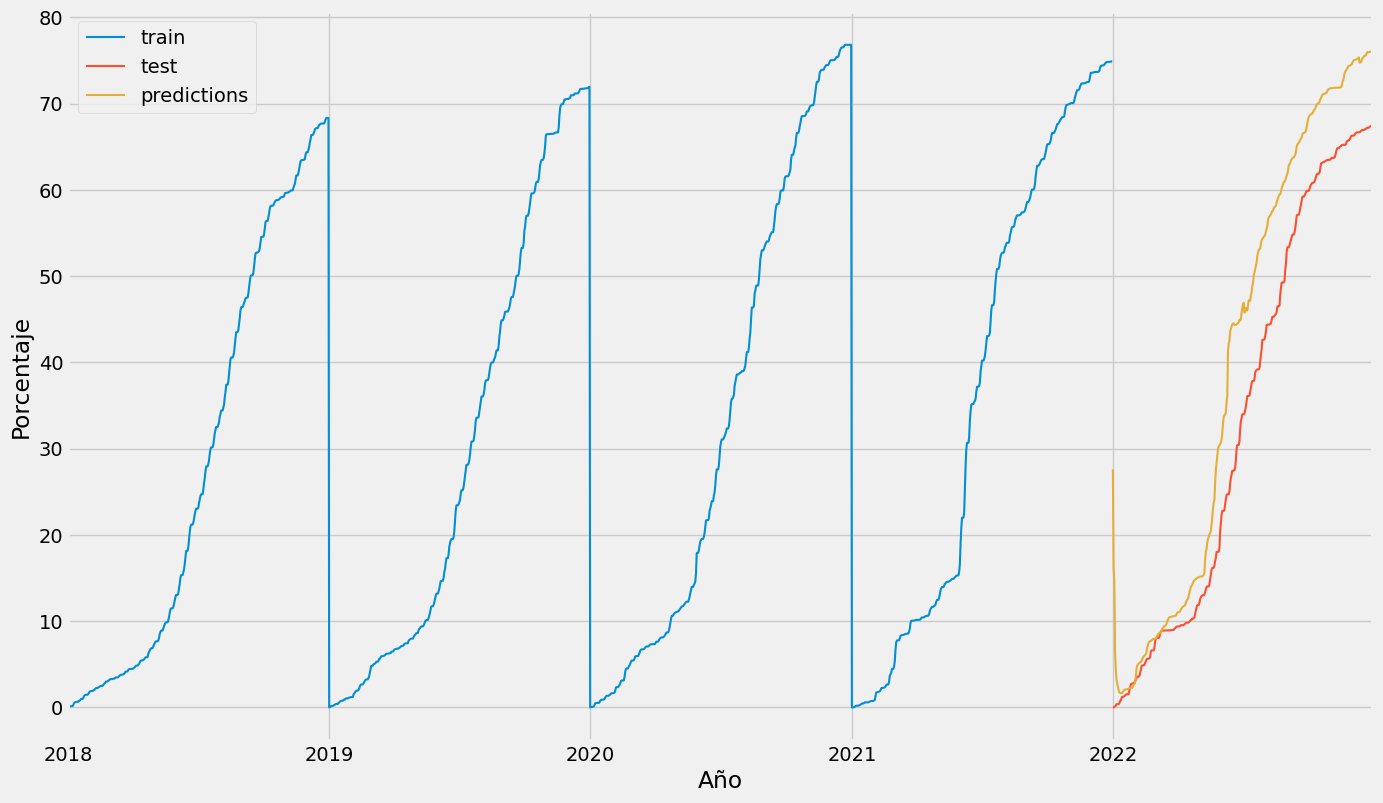

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 9))
data_train['Porcentaje'].plot(ax=ax, label='train')
data_test['Porcentaje'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.xlabel('Año')
plt.ylabel('Porcentaje')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Porcentaje'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 71.7128662232878


##### Número de predictores: 730

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=rs),
                lags      = 730
             )
#Importante: lags = 730 significa que, el modelo, utiliza como predictores los 730 días anteriores.
#(Esto depende de la frecuencia indicada en los datos, si ésta fuera MS (meses), significaría que está cogiendo los 730 meses anteriores)

forecaster.fit(y=data_train['Porcentaje'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228

In [ ]:
# Predictions
# ==============================================================================
steps = int(df_JAX2.shape[0]*0.2)
predictions = forecaster.predict(steps=steps)
predictions.head(10)

2022-01-01    39.4501
2022-01-02    19.7690
2022-01-03     4.5222
2022-01-04     0.7431
2022-01-05     0.5798
2022-01-06     0.6075
2022-01-07     0.7275
2022-01-08     0.7878
2022-01-09     1.0229
2022-01-10     1.1043
Freq: D, Name: pred, dtype: float64

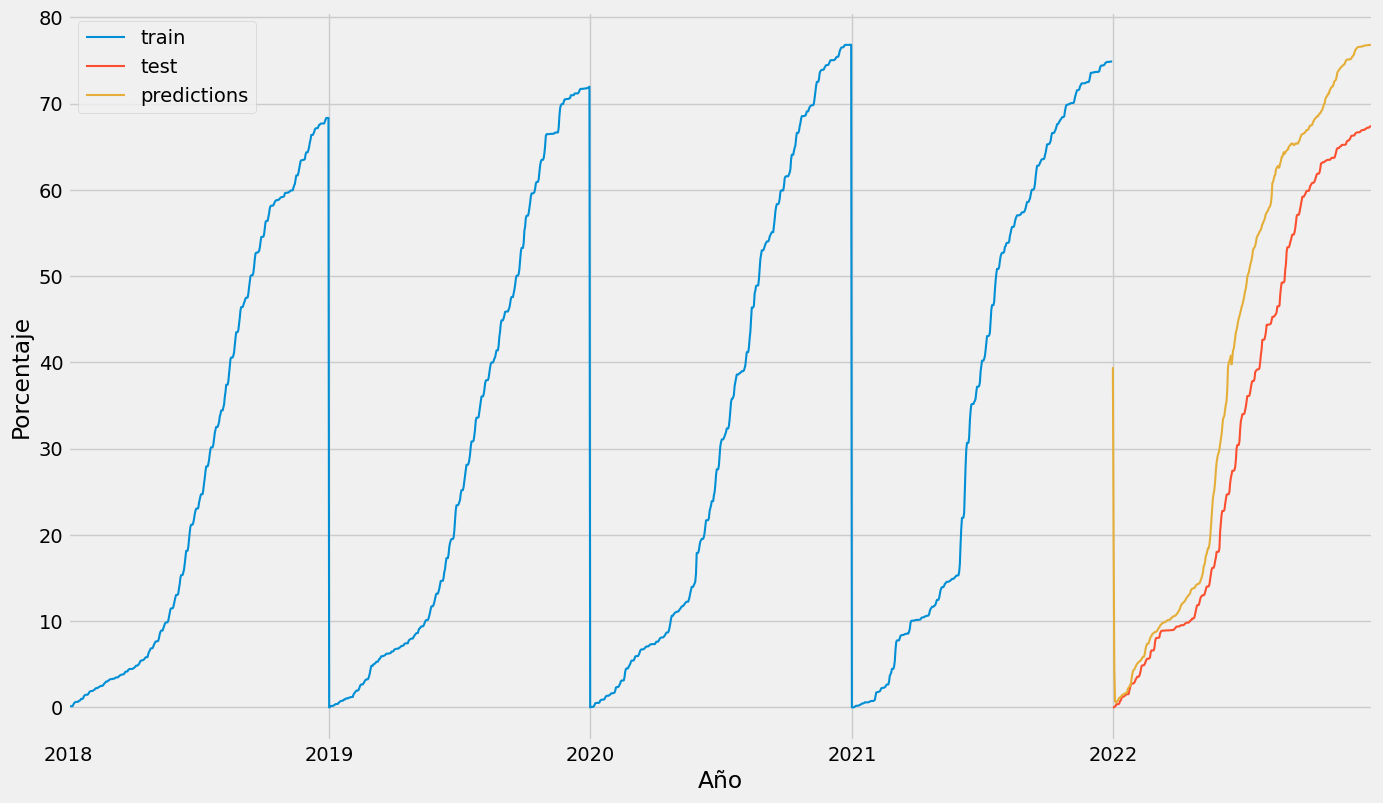

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 9))
data_train['Porcentaje'].plot(ax=ax, label='train')
data_test['Porcentaje'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.xlabel('Año')
plt.ylabel('Porcentaje')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Porcentaje'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 86.33027203350692


##### Número de predictores: 960

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=rs),
                lags      = 960
             )
#Importante: lags = 730 significa que, el modelo, utiliza como predictores los 730 días anteriores.
#(Esto depende de la frecuencia indicada en los datos, si ésta fuera MS (meses), significaría que está cogiendo los 730 meses anteriores)

forecaster.fit(y=data_train['Porcentaje'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228

In [ ]:
# Predictions
# ==============================================================================
steps = int(df_JAX2.shape[0]*0.2)
predictions = forecaster.predict(steps=steps)
# predictions.head(10)
predictions

2022-01-01    33.2506
2022-01-02     5.7716
2022-01-03     3.4379
2022-01-04     1.2427
2022-01-05     0.5382
               ...   
2022-12-27    51.7925
2022-12-28    51.8020
2022-12-29    51.7398
2022-12-30    51.7398
2022-12-31    51.5399
Freq: D, Name: pred, Length: 365, dtype: float64

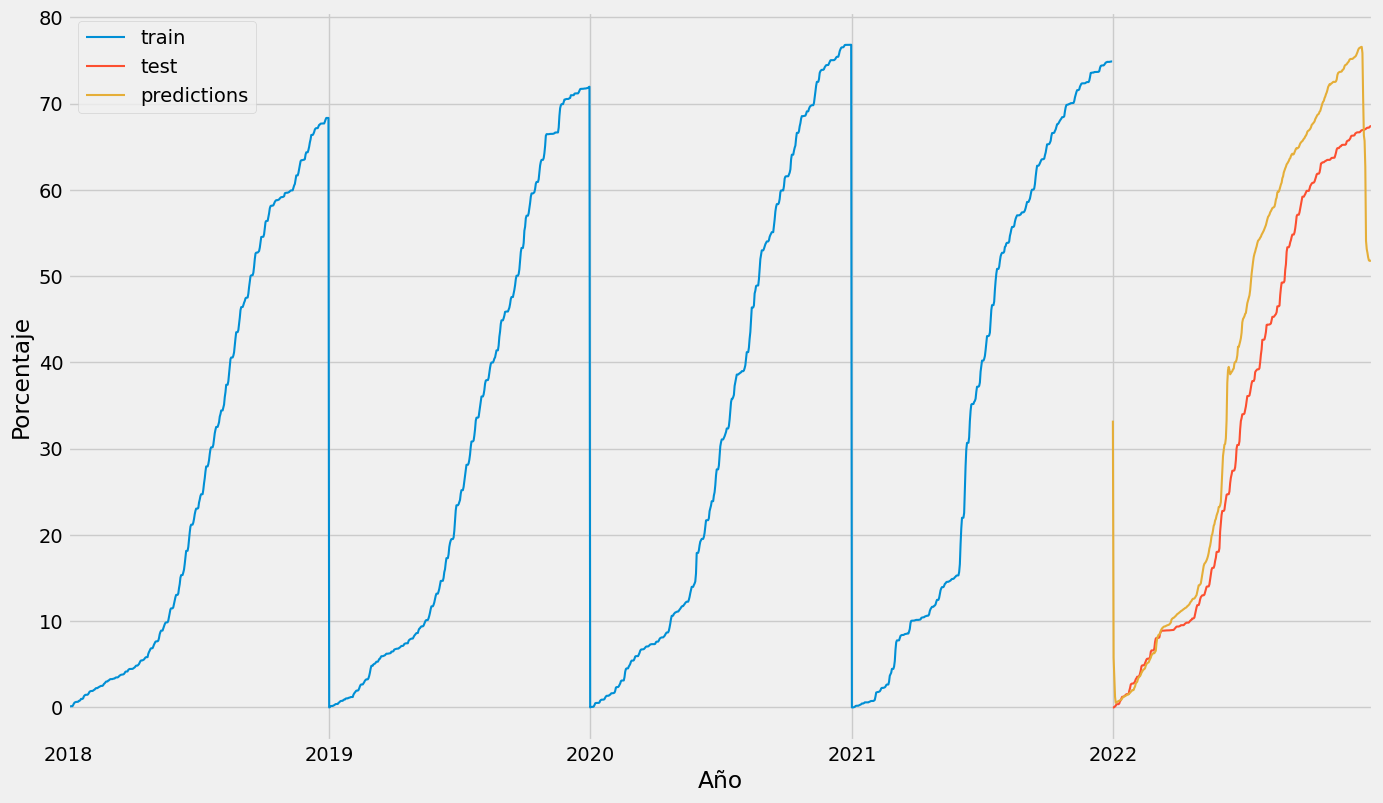

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 9))
data_train['Porcentaje'].plot(ax=ax, label='train')
data_test['Porcentaje'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
plt.xlabel('Año')
plt.ylabel('Porcentaje')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Porcentaje'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 68.59506865621918
